In [19]:
import pandas as pd
from datetime import datetime
from zoe import cases, query, pickle, find_previous, plot_study, plot_study_evolution

In [108]:
uk_active_cases = query("SELECT * FROM uk_active_cases", index='date')
uk_active_cases.index = pd.to_datetime(uk_active_cases.index, format='%Y%m%d')
uk_active_cases

,cartodb_id,the_geom,the_geom_webmercator,corrected_covid_positive
date,,,,
2020-06-12,25777,None,None,88442.732585
2020-06-13,25778,None,None,81698.009934
2020-06-14,25779,None,None,75465.550115
2020-06-15,25780,None,None,69766.531694
2020-06-16,25781,None,None,64771.692188
...,...,...,...,...
2021-01-19,25998,None,None,694756.402391
2021-01-20,25999,None,None,671214.281553
2021-01-21,26000,None,None,647882.291109


In [109]:
curr_date = uk_active_cases.index.max()
print(pickle(uk_active_cases, 'uk_active_cases', curr_date))

/Users/chris/coronavirus/data/zoe_uk_active_cases_2021-01-23_2021-01-23-18-13.pickle


In [110]:
prev_date, prev_uk_active_cases = find_previous(curr_date)

/Users/chris/coronavirus/data/zoe_uk_active_cases_2021-01-22_2021-01-22-16-21.pickle


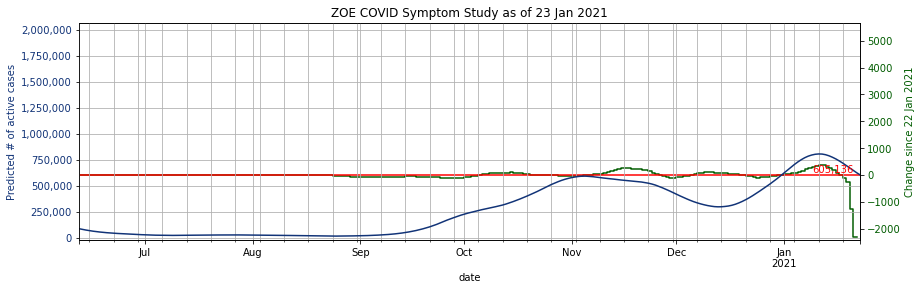

In [111]:
plot_study(curr_date, prev_date, uk_active_cases, prev_uk_active_cases)

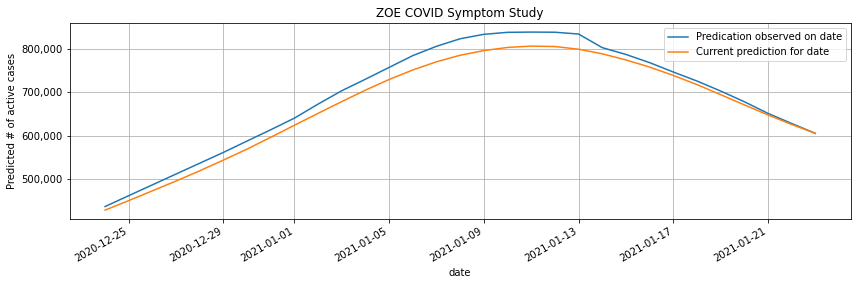

In [112]:
plot_study_evolution(curr_date, days=30)

In [113]:
prevalence_map = query("SELECT * FROM prevalence_map")
prevalence_map['percentage'] = prevalence_map['percentage'].astype(float)

In [114]:
for_date, = prevalence_map['data_status'].unique()
print(pickle(prevalence_map, 'prevalence_map', datetime.strptime(for_date, '%H:%M:%S %d-%m-%Y')))

/Users/chris/coronavirus/data/zoe_prevalence_map_2021-01-23_2021-01-23-18-13.pickle


In [115]:
prevalence_map[['lad16nm', 'lad16cd', 'percentage']].sort_values('percentage', ascending=False)[:10]

,lad16nm,lad16cd,percentage
258,Redditch,E07000236,3.807232
341,Ealing,E09000009,3.072875
334,Wrexham,W06000006,2.810042
3,Stockton-on-Tees,E06000004,2.499677
379,Tower Hamlets,E09000030,2.431247
322,Islington,E09000019,2.350636
190,Breckland,E07000143,2.187197
381,Rhondda Cynon Taf,W06000016,2.117429
172,Ribble Valley,E07000124,2.050186
312,Bexley,E09000004,2.042305
